In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing data and creating a dataframe

The dataset contains several Non-functional requirements and functional requirements for different types of software products. The labellings specifies the following requirements.

1. Functional (F)
2. Availability (A)
3. Fault Tolerance (FT)
4. Legal (L)
5. Look & Feel (LF)
6. Maintainability (MN)
7. Operational (O)
8. Performance (PE)
9. Portability (PO)
10. Scalability (SC)
11. Security (SE)
12. Usability (US)

In [3]:
def get_req_df(filepath,separator):
    requirement_statement = list()
    requirement_type = list()
    
    with open(filepath) as filePointer:
        for line_counter, line in enumerate(filePointer):
            
            requirement_list = str(line).strip().split(separator) # Contains List of values in the column
            
            requirement_type.append(requirement_list[0])
            requirement_statement.append(requirement_list[1])
    reqs_frame = pd.DataFrame({'requirement': requirement_statement, 'category':requirement_type })
    return reqs_frame

In [4]:
train_filepath = '/kaggle/input/software-requirements-dataset/nfr.txt'
test_filepath = '/kaggle/input/software-requirements-dataset/test.txt'
separator = ':'

train_df = get_req_df(train_filepath,separator)
test_df = get_req_df(test_filepath,separator)

In [102]:
train_df.head()
#test_df.head()

,requirement,category
0,The system shall refresh the display every 60 ...,PE
1,The application shall match the color of the s...,LF
2,If projected the data must be readable. On ...,US
3,The product shall be available during normal ...,A
4,If projected the data must be understandable...,US


# Prelimnary data analysis
Analyze the data and dervice insights and meaning that can be useful for modelling.

[Text(0, 0.5, 'Requirement categories'),
 Text(0.5, 0, 'Number of Requirements')]

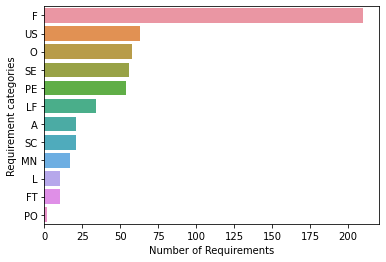

In [101]:
# Requirement types and counts
unique_value_counts = train_df.category.value_counts()
unique_value_index = train_df.category.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Number of Requirements',ylabel='Requirement categories')

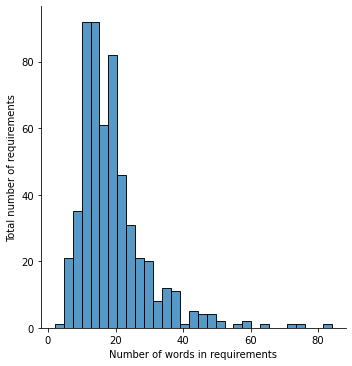

In [100]:
# Length distribution of all the Requirements text
req_len_hist = [len(str(req_text).strip().split()) for req_text in train_df.requirement]
req_hist_obj = sns.displot(req_len_hist)
req_hist_obj.set(xlabel='Number of words in requirements',ylabel='Total number of requirements')

[Text(0, 0.5, 'Number of Tokens'),
 Text(0.5, 0, 'Whitespaced word tokens in Requirements')]

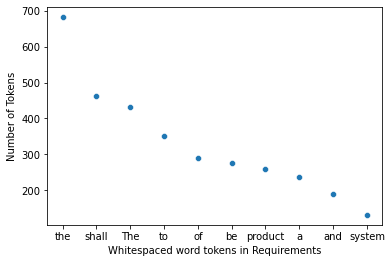

In [8]:
# Top 10 words found in Requirement
wp_tokenizer = nltk.tokenize.WhitespaceTokenizer()
wp_tokens_req = [wp_tokenizer.tokenize(req_text) for req_text in train_df.requirement]
all_token_dict = dict()

for token_list in wp_tokens_req:
    for token in token_list:
        if token not in all_token_dict:
            all_token_dict[token] = 1
        else:
            all_token_dict[token] +=1

# Sort and get top 10
sorted_token_dict = {key: value for key, value in sorted(all_token_dict.items(), key=lambda item: item[1],reverse=True)}
top_words = list()
top_values = list()

for key,value in sorted_token_dict.items():
    top_words.append(key)
    top_values.append(value)

req_hist_token = sns.scatterplot(x=top_words[:10],y=top_values[:10])
req_hist_token.set(xlabel='Whitespaced word tokens in Requirements',ylabel='Number of Tokens')

# It can be observed that the most of the words in the requirements are stop words and they can be removed to train better models.

# Modelling and training
Now we have some insight into how these requirements are written and what are the words used. We can train our model to predict new requirements.

# Word Vectors and Classic ML Algorithms

In [32]:
# Using Word Vectors
import spacy

nlp = spacy.load('en_core_web_lg')

# Disable Spacy pipelines and create an array of requirement vectors (Both train and test set)
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in train_df.requirement])
    test_vector = np.array([nlp(text).vector for text in test_df.requirement])
    
doc_vectors.shape

(556, 300)

In [58]:
from sklearn.model_selection import train_test_split

# Test train split on train data
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, train_df.category,
                                                    test_size=0.5, random_state=1)

# Support Vector Machine

In [59]:
from sklearn.svm import LinearSVC

# Set dual=False to speed up training, and it's not needed
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)

# Tested on the test set
print(f"Accuracy: {svc.score(test_vector, test_df.category) * 100:.3f}%", )

Accuracy: 80.000%


# Decision Tree

In [64]:
from sklearn import tree

# Initialize and Fit the Model
req_dTree = tree.DecisionTreeClassifier(random_state=1,max_depth=1000)
dTree_model = req_dTree.fit(X_train, y_train)

print(f"Accuracy: {dTree_model.score(test_vector, test_df.category) * 100:.3f}%", )

Accuracy: 54.286%


# Ensemble Models

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

req_ada = AdaBoostClassifier(n_estimators=100)
req_ada.fit(X_train,y_train)

print(f"Accuracy: {req_ada.score(test_vector, test_df.category) * 100:.3f}%", )

Accuracy: 64.286%
